In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
from keras.layers import Input, Dense, Lambda, Layer, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras import metrics, optimizers
from keras.callbacks import Callback
import keras

import pydot
import graphviz
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
print(keras.__version__)
tf.__version__

2.0.5


'1.2.1'

In [3]:
# get a GPU session and reserve memory
def get_session(gpu_fraction=0.3):
    '''Assume that you have 6GB of GPU memory and want to allocate ~2GB'''

    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

KTF.set_session(get_session(.90))

In [4]:
# Function for reparameterization trick to make model differentiable
def sampling(args):
    
    import tensorflow as tf
    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)
    
    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z


class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training

    """
    def __init__(self, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

In [5]:
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa
    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

In [6]:
%matplotlib inline
plt.style.use('seaborn-notebook')

In [7]:
np.random.seed(123)

# Vars and HPs

In [8]:
# Set hyper parameters
original_dim = 300000
latent_dim = 100

batch_size = 50
epochs = 50
learning_rate = 0.0005

epsilon_std = 1.0
beta = K.variable(0)
kappa = 1

# Load methylation data

In [10]:
methyl_file = os.path.join('data', 'TCGA_BRCA_top300kMAD_cpg.tsv')
methyl_df = pd.read_table(methyl_file, index_col=0)
print(methyl_df.shape)
methyl_df.head(5)

(862, 300000)


,cg16620382,cg27363327,cg01893212,cg17463633,cg01682111,cg27260772,cg17154724,cg13885357,cg07813142,cg20399616,...,cg12439388,cg02310273,cg23337068,cg05227616,cg13581507,cg17716453,cg04868764,cg12670756,cg16674475,cg02696971
7796806090_R04C01,0.055168,0.068544,0.566052,0.920830,0.148795,0.070930,0.637561,0.566779,0.606875,0.622774,...,0.913334,0.910522,0.930061,0.047445,0.143646,0.014610,0.066978,0.056034,0.953544,0.906814
6285633051_R04C01,0.137893,0.074701,0.626088,0.318388,0.819280,0.173150,0.618894,0.387909,0.429214,0.506081,...,0.941507,0.907734,0.918301,0.044297,0.119243,0.012247,0.068399,0.082936,0.961145,0.898146
9993943017_R04C02,0.591397,0.289356,0.215336,0.482832,0.650826,0.047947,0.613534,0.231326,0.062284,0.715812,...,0.891870,0.907416,0.876772,0.046259,0.122555,0.022389,0.058038,0.110625,0.875639,0.865706
7796806090_R03C01,0.027590,0.042454,0.026760,0.931495,0.035875,0.917678,0.018935,0.429940,0.026646,0.026751,...,0.911154,0.918988,0.922758,0.044816,0.118310,0.011996,0.081457,0.072075,0.950406,0.897170
3999997079_R01C02,0.063119,0.070341,0.789728,0.083000,0.450423,0.031449,0.916007,0.121966,0.029224,0.014501,...,0.893443,0.927593,0.933655,0.027989,0.084445,0.010027,0.033802,0.066549,0.951092,0.920060


In [12]:
# Reduce the data size for model testing
methyl_df2 = methyl_df.sample(original_dim, axis=1) # this is not correct when real training happens
print(methyl_df2.shape)
methyl_df2.head(5)

(862, 300000)


,cg05609218,cg22931085,cg17251874,cg15207619,cg18069268,cg11787508,cg13337949,cg04485516,cg01828530,cg09648722,...,ch.9.1173620F,cg04300684,cg16770054,cg18900959,cg14847845,cg23107916,cg16751754,cg15457745,cg00849943,cg17289222
7796806090_R04C01,0.545441,0.853057,0.649835,0.259499,0.938481,0.526505,0.128962,0.884376,0.770399,0.100277,...,0.087824,0.487777,0.875961,0.873091,0.874440,0.653986,0.917380,0.047611,0.044446,0.699034
6285633051_R04C01,0.664495,0.821738,0.551126,0.240213,0.934988,0.462401,0.070426,0.943853,0.624185,0.087996,...,0.103713,0.509940,0.838878,0.896937,0.679916,0.429626,0.762457,0.037634,0.033631,0.976383
9993943017_R04C02,0.592440,0.777425,0.292605,0.178106,0.571350,0.886400,0.125322,0.867190,0.750185,0.094839,...,0.157848,0.600940,0.918040,0.833179,0.676394,0.380983,0.903616,0.041686,0.049972,0.901056
7796806090_R03C01,0.431014,0.902831,0.475521,0.063569,0.926847,0.234075,0.073336,0.393760,0.750900,0.067018,...,0.113222,0.503443,0.837939,0.892743,0.509583,0.899939,0.704740,0.042766,0.030920,0.976166
3999997079_R01C02,0.451867,0.292289,0.205509,0.044008,0.835985,0.838651,0.071316,0.915101,0.401685,0.093245,...,0.043027,0.207917,0.909365,0.728409,0.505044,0.072527,0.809161,0.030781,0.026116,0.968231


In [13]:
# Split 10% test set randomly
test_set_percent = 0.1
methyl_test_df = methyl_df2.sample(frac=test_set_percent)
methyl_train_df = methyl_df2.drop(methyl_test_df.index)

# Encoder

In [9]:
# Input place holder for RNAseq data with specific input size
methyl_input = Input(shape=(original_dim, ))

# Input layer is compressed into a mean and log variance vector of size `latent_dim`
# Each layer is initialized with glorot uniform weights and each step (dense connections, batch norm,
# and relu activation) are funneled separately
# Each vector of length `latent_dim` are connected to the methyl input tensor
z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(methyl_input)
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(methyl_input)
z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

# return the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a `latent_dim` output
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])

# Decoder

In [10]:
# The decoding layer is much simpler with a single layer glorot uniform initialized and sigmoid activation
decoder_to_reconstruct = Dense(original_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
methyl_reconstruct = decoder_to_reconstruct(z)

# Encoder + Decoder = VAE

In [11]:
adam = optimizers.Adam(lr=learning_rate)
vae_layer = CustomVariationalLayer()([methyl_input, methyl_reconstruct])
vae = Model(methyl_input, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])

vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 300000)        0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 100)           30000100    input_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 100)           30000100    input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 100)           400         dense_1[0][0]                    
___________________________________________________________________________________________

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.


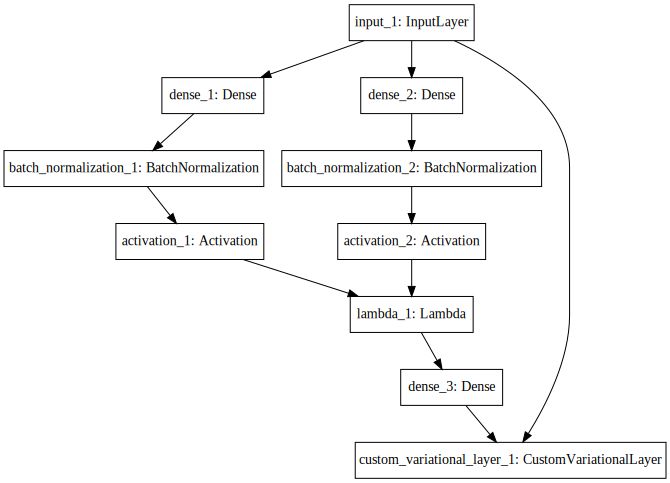

In [12]:
# Visualize the connections of the custom VAE model
output_model_file = os.path.join('figures', 'onehidden_vae_architecture.eps')
plot_model(vae, to_file=output_model_file)

SVG(model_to_dot(vae).create(prog='dot', format='svg'))

# Train the model

In [17]:
%%time
hist = vae.fit(np.array(methyl_train_df),
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(np.array(methyl_test_df), np.array(methyl_test_df)),
               callbacks=[WarmUpCallback(beta, kappa)])

Train on 776 samples, validate on 86 samples
Epoch 1/50
776/776 [==============================] - 6s - loss: 198749.3102 - val_loss: 2603136.1512

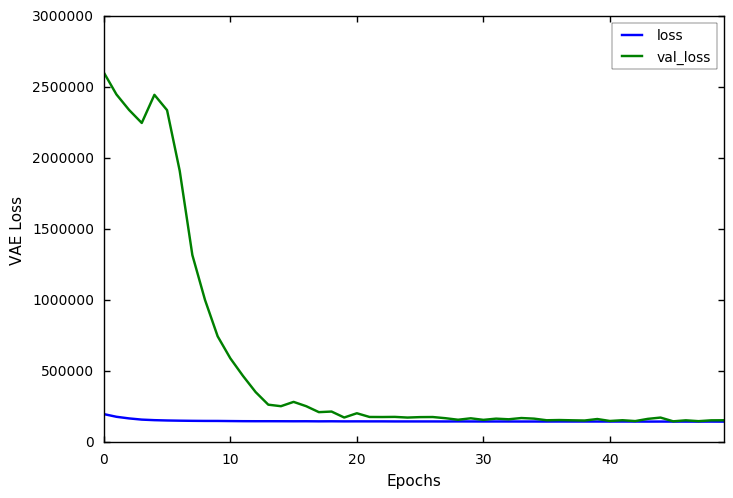

In [18]:
# Visualize training performance
history_df = pd.DataFrame(hist.history)
hist_plot_file = os.path.join('figures', 'onehidden_vae_training_300K-100.pdf') 
#hist_plot_file = os.path.join('figures', 'onehidden_vae_training_30K-1000.pdf') 
#hist_plot_file = os.path.join('figures', 'onehidden_vae_training_100K-10.pdf')
#hist_plot_file = os.path.join('figures', 'onehidden_vae_training_100K-100.pdf')
#hist_plot_file = os.path.join('figures', 'onehidden_vae_training_10K-100.pdf')
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()
fig.savefig(hist_plot_file)

# Compile and output models

## Encoder

In [19]:
# Model to compress input
encoder = Model(methyl_input, z_mean_encoded)

In [20]:
# Encode methyl into the hidden/latent representation - and save output
encoded_methyl_df = encoder.predict_on_batch(methyl_df2)
encoded_methyl_df = pd.DataFrame(encoded_methyl_df, index=methyl_df2.index)

encoded_methyl_df.columns.name = 'sample_id'
encoded_methyl_df.columns = encoded_methyl_df.columns + 1
#encoded_file = os.path.join('data', 'encoded_methyl_onehidden_warmup_batchnorm_100K-10.tsv')
#encoded_file = os.path.join('data', 'encoded_methyl_onehidden_warmup_batchnorm_100K-100.tsv')
#encoded_file = os.path.join('data', 'encoded_methyl_onehidden_warmup_batchnorm_10K-100.tsv')
#encoded_file = os.path.join('data', 'encoded_methyl_onehidden_warmup_batchnorm_300K-1000.tsv')
encoded_file = os.path.join('data', 'encoded_methyl_onehidden_warmup_batchnorm_300K-100.tsv')
encoded_methyl_df.to_csv(encoded_file, sep='\t')

In [21]:
# What are the most and least activated nodes
top_active_nodes = encoded_methyl_df.sum(axis=0).sort_values(ascending=False)
print(top_active_nodes.head(10))
top_active_nodes.tail(10)

sample_id
72    2689.523682
19    2261.734619
3     2233.960938
52    2158.137939
76    1944.653687
66    1915.777466
78    1817.843872
55    1793.530273
39    1703.847656
64    1642.765991
dtype: float32


sample_id
88    98.864792
43    89.600433
40    73.793655
25    70.327644
93    68.710793
97    66.469162
51    40.531780
89    37.308762
45    21.683561
42    19.556742
dtype: float32

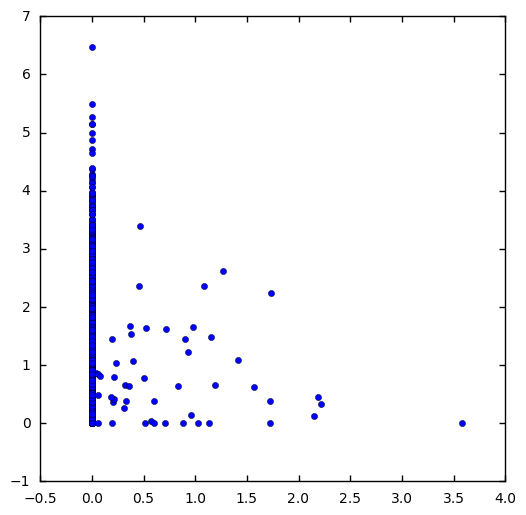

In [24]:
# Example distribution of latent layer
plt.figure(figsize=(6, 6))
plt.scatter(encoded_methyl_df.iloc[:, 50], encoded_methyl_df.iloc[:, 8])

## Decoder

In [25]:
# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim, ))  # can generate from any sampled z vector
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

In [26]:
# How well does the model reconstruct the input Methylation data
input_methyl_reconstruct = decoder.predict(np.array(encoded_methyl_df))
input_methyl_reconstruct = pd.DataFrame(input_methyl_reconstruct, index=methyl_df2.index,
                                        columns=methyl_df2.columns)
input_methyl_reconstruct.head(3)

,cg05609218,cg22931085,cg17251874,cg15207619,cg18069268,cg11787508,cg13337949,cg04485516,cg01828530,cg09648722,...,ch.9.1173620F,cg04300684,cg16770054,cg18900959,cg14847845,cg23107916,cg16751754,cg15457745,cg00849943,cg17289222
7796806090_R04C01,0.672033,0.876269,0.767542,0.123064,0.973082,0.764291,0.045026,0.967063,0.780857,0.039814,...,0.037846,0.606236,0.931593,0.926697,0.860495,0.698333,0.932990,0.022119,0.015452,0.980561
6285633051_R04C01,0.729906,0.843547,0.671565,0.059589,0.977977,0.790845,0.022084,0.983528,0.836831,0.024214,...,0.022224,0.636163,0.962394,0.942780,0.848625,0.553571,0.961438,0.012269,0.008690,0.993206
9993943017_R04C02,0.693098,0.843114,0.466781,0.036274,0.960945,0.771037,0.029470,0.975914,0.902240,0.032599,...,0.041737,0.697151,0.967159,0.921050,0.807059,0.539523,0.965884,0.018012,0.019237,0.994381


In [27]:
print(methyl_df2.shape)
methyl_df2.head(3)

(862, 300000)


,cg05609218,cg22931085,cg17251874,cg15207619,cg18069268,cg11787508,cg13337949,cg04485516,cg01828530,cg09648722,...,ch.9.1173620F,cg04300684,cg16770054,cg18900959,cg14847845,cg23107916,cg16751754,cg15457745,cg00849943,cg17289222
7796806090_R04C01,0.545441,0.853057,0.649835,0.259499,0.938481,0.526505,0.128962,0.884376,0.770399,0.100277,...,0.087824,0.487777,0.875961,0.873091,0.874440,0.653986,0.917380,0.047611,0.044446,0.699034
6285633051_R04C01,0.664495,0.821738,0.551126,0.240213,0.934988,0.462401,0.070426,0.943853,0.624185,0.087996,...,0.103713,0.509940,0.838878,0.896937,0.679916,0.429626,0.762457,0.037634,0.033631,0.976383
9993943017_R04C02,0.592440,0.777425,0.292605,0.178106,0.571350,0.886400,0.125322,0.867190,0.750185,0.094839,...,0.157848,0.600940,0.918040,0.833179,0.676394,0.380983,0.903616,0.041686,0.049972,0.901056


In [ ]:
#methylation_out_file = os.path.join('data', 'TCGA_BRCA_30kgenerated_cpg.tsv')
methylation_out_file = os.path.join('data', 'TCGA_BRCA_300kgenerated_cpg_100latent.tsv')
methyl_df2.to_csv(methylation_out_file, sep='\t')

In [ ]:
#encoder_model_file = os.path.join('models', 'encoder_onehidden_vae_100K-10.hdf5')
#decoder_model_file = os.path.join('models', 'decoder_onehidden_vae_100K-10.hdf5')

#encoder_model_file = os.path.join('models', 'encoder_onehidden_vae_100K-100.hdf5')
#decoder_model_file = os.path.join('models', 'decoder_onehidden_vae_100K-100.hdf5')

#encoder_model_file = os.path.join('models', 'encoder_onehidden_vae_10K-100.hdf5')
#decoder_model_file = os.path.join('models', 'decoder_onehidden_vae_10K-100.hdf5')

#encoder_model_file = os.path.join('models', 'encoder_onehidden_vae_30K-1000.hdf5')
#decoder_model_file = os.path.join('models', 'decoder_onehidden_vae_30K-1000.hdf5')

#encoder_model_file = os.path.join('models', 'encoder_onehidden_vae_300K-1000.hdf5')
#decoder_model_file = os.path.join('models', 'decoder_onehidden_vae_300K-1000.hdf5')

encoder_model_file = os.path.join('models', 'encoder_onehidden_vae_300K-100.hdf5')
decoder_model_file = os.path.join('models', 'decoder_onehidden_vae_300K-100.hdf5')

encoder.save(encoder_model_file)
decoder.save(decoder_model_file)